# 라이브러리 불러오기

In [251]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
# 모든 열 출력 설정
pd.set_option('display.max_columns', None)

# 데이터 가져오기

In [253]:
# 데이터 가져오기

#고객정보 테이블
customers = pd.read_csv("olist_customers_dataset.csv")

#판매자정보 테이블
sellers = pd.read_csv("olist_sellers_dataset.csv")

#주문정보 테이블
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")

#상품정보 테이블
products = pd.read_csv("olist_products_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

#지역정보 테이블
geolocation = pd.read_csv("olist_geolocation_dataset.csv")

# 데이터 전처리

## Customers 전처리

In [254]:
# customers 고객정보 테이블
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


| 컬럼명                        | 설명                                                                          |
| -------------------------- | --------------------------------------------------------------------------- |
| customer_id              | 고객의 고유 식별자. 주문과 연결될 때 사용됨 (`orders.customer_id`와 매칭)                        |
| customer_unique_id       | 동일 고객의 중복 구매를 구분하기 위한 유니크 식별자. 같은 사람이 여러 `customer_id`로 주문할 수 있으므로 이를 묶는 용도 |
| customer_zip_code_prefix | 고객 주소의 우편번호 앞자리 (5자리 prefix). 지역 정보를 대략적으로 나타냄                              |
| customer_city            | 고객이 거주하는 도시 이름                                                              |
| customer_state           | 고객이 거주하는 주(州, State). 예: SP(São Paulo), RJ(Rio de Janeiro) 등                |


In [255]:
# Customer 테이블 결측치 확인하기
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


**결측치 없음**으로 확인됩니다.    
다음은 이상치가 있는지 확인해 보겠습니다.    

customer_zip_code_prefix 칼럼의 우편번호가 모두 정확한지 확인합니다.    
브라질의 우편번호는 5자리와 3자리의 숫자가 - (하이픈)으로 연결된 형태이며 테이블에는 앞 5자리만 사용합니다.    
우선 5자리가 아닌 칼럼의 값들을 가져와서 확인해보겠습니다.

In [256]:
# 예: 5자리 아닌 우편번호 prefix 출력
invalid_zip_codes = customers[customers['customer_zip_code_prefix'].astype(str).str.len() != 5]

print(invalid_zip_codes['customer_zip_code_prefix'])
print('='*20)
total = len(customers['customer_zip_code_prefix'])
invalid = len(invalid_zip_codes['customer_zip_code_prefix'])

print(f"총 {total} 개의 우편번호 중 {invalid} 개가 우편번호 5자리가 아닙니다.")


1        9790
2        1151
3        8775
6        4534
13       5704
         ... 
99430    6727
99434    7790
99436    3937
99437    6764
99440    6703
Name: customer_zip_code_prefix, Length: 23995, dtype: int64
총 99441 개의 우편번호 중 23995 개가 우편번호 5자리가 아닙니다.


**총 23995개의 우편번호가 5자리가 아닌것으로 확인됩니다.**    
scv파일로 변환하면서 맨앞자리 0들은 모두 제거되었을수도 있다고 생각되어 데이터를 확인하여 검증하겠습니다.

1. 0으로 시작하는 우편번호가 있는지 확인하기.
2. 3~1 자리 수의 우편번호가 있는지 확인하기.
3. 4자리수 우편번호에 0으로 시작하는 우편번호가 있는지 확인하기.
4. geolocation 테이블의 우편번호와 일치하는지 확인하기.

In [257]:
#0으로 시작하는 우편번호가 있는지 확인하기.
# 고객 테이블에서 우편번호를 문자열로 변환
customer_zip_str = customers['customer_zip_code_prefix'].astype(str)

# 길이가 5자리이고 '0'으로 시작하는 zip code만 필터링
leading_zero_zips = customer_zip_str[(customer_zip_str.str.len() == 5) & (customer_zip_str.str.startswith('0'))]

# 결과 출력
print(leading_zero_zips)

# 개수 출력
print("=" * 20)
print(f"총 {len(customers)}개의 고객 우편번호 중 {len(leading_zero_zips)}개가 '0'으로 시작하는 우편번호입니다.")


Series([], Name: customer_zip_code_prefix, dtype: object)
총 99441개의 고객 우편번호 중 0개가 '0'으로 시작하는 우편번호입니다.


In [258]:
#3~1 자리 수의 우편번호가 있는지 확인하기.
# 고객 우편번호 컬럼을 문자열로 변환한 후, 길이 기준으로 필터링
short_zip_codes = customers[customers['customer_zip_code_prefix'].astype(str).str.len() <= 3]

# 결과 출력
print(short_zip_codes['customer_zip_code_prefix'])

# 총 개수도 함께 출력
print("=" * 20)
print(f"총 {len(customers)}개의 우편번호 중 {len(short_zip_codes)}개가 3자리 이하입니다.")

Series([], Name: customer_zip_code_prefix, dtype: int64)
총 99441개의 우편번호 중 0개가 3자리 이하입니다.


In [259]:
# 4자리 우편번호 중 '0'으로 시작하는 값이 있는지 확인
# 1. 먼저 4자리 zip prefix만 추출
zip_4digit = customers[customers['customer_zip_code_prefix'].astype(str).str.len() == 4]

# 2. 문자열로 변환한 후 '0'으로 시작하는 경우 필터링
zip_start_with_zero = zip_4digit[zip_4digit['customer_zip_code_prefix'].astype(str).str.startswith('0')]

# 3. 결과 출력
print(zip_start_with_zero['customer_zip_code_prefix'])

# 4. 개수 출력
print("=" * 20)
print(f"총 {len(zip_4digit)}개의 4자리 우편번호 중 {len(zip_start_with_zero)}개가 0으로 시작합니다.")

Series([], Name: customer_zip_code_prefix, dtype: int64)
총 23995개의 4자리 우편번호 중 0개가 0으로 시작합니다.


In [260]:
# 4자리 우편번호가 geolocation 테이블에도 4자리로 존재하는지 확인
# 1. customers 테이블의 4자리 zip prefix 추출
customer_zip_4 = set(customers[customers['customer_zip_code_prefix'].astype(str).str.len() == 4]['customer_zip_code_prefix'].astype(str))

# 2. geolocation 테이블의 4자리 zip prefix 추출
geo_zip_4 = set(geolocation[geolocation['geolocation_zip_code_prefix'].astype(str).str.len() == 4]['geolocation_zip_code_prefix'].astype(str))

# 3. 두 집합의 교집합 (양쪽에 모두 존재하는 4자리 zip)
intersection_zip_4 = customer_zip_4.intersection(geo_zip_4)

# 4. 결과 출력
print(f"customers 테이블의 4자리 zip 개수: {len(customer_zip_4)}")
print(f"geolocation 테이블의 4자리 zip 개수: {len(geo_zip_4)}")
print(f"양쪽에 모두 일치하는 4자리 zip 개수: {len(intersection_zip_4)}")
print(f"일치율: {len(intersection_zip_4) / len(customer_zip_4) * 100:.2f}%")

customers 테이블의 4자리 zip 개수: 3869
geolocation 테이블의 4자리 zip 개수: 4354
양쪽에 모두 일치하는 4자리 zip 개수: 3861
일치율: 99.79%


In [261]:
# customers에는 있지만 geolocation에는 없는 4자리 zip
only_in_customers = customer_zip_4 - geo_zip_4
print("customers에만 있는 4자리 zip:", list(only_in_customers))

customers에만 있는 4자리 zip: ['2140', '6930', '7412', '7430', '7784', '7729', '8980', '8342']


차후 geolocation 칼럼과 merge하면서 NULL값에 대해 처리해주도록 하겠습니다.

위 정보를 모두 조합해봤을때 브라질의 우편번호는 1970년도부터 앞5자리로 정해져왔고,    
CSV 변환하면서 0으로시작하는 우편번호의 0들이 빠졋을거라고 생각되어 4자리수 우편번호 맨 앞자리 0을 넣어주겠습니다.    
**Tip으로 파이썬에서 숫자형의 데이터가 0으로 시작하는 경우 0은 사라진 숫자만 나타나기 때문에 문자열을 유지하도록 하겠습니다.**    
우선은 customers 테이블에서 ziq 코드만 0을 넣어주고 geolocation의 경우 결측치와 이상치를 확인하면서 넣어주도록 하겠습니다.    

In [262]:
# 1. customer_zip_code_prefix를 문자열로 변환 후, 5자리로 앞에 0을 채워줌
customers['customer_zip_code_prefix'] = customers['customer_zip_code_prefix'].astype(str).str.zfill(5)

# 2. 보정된 결과 일부 확인
print(customers['customer_zip_code_prefix'].head())

# 3. 여전히 5자리가 아닌 값이 있는지 확인 (정상이라면 0이어야 함)
invalid_after_fix = customers[customers['customer_zip_code_prefix'].str.len() != 5]
print("=" * 20)
print(f"보정 후에도 여전히 5자리가 아닌 우편번호 수: {len(invalid_after_fix)}")

0    14409
1    09790
2    01151
3    08775
4    13056
Name: customer_zip_code_prefix, dtype: object
보정 후에도 여전히 5자리가 아닌 우편번호 수: 0


In [263]:
# 변경된 customer 테이블 info(), head() 확인하기
print(customers.info())
print('='*20)
print(customers.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  object
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: object(5)
memory usage: 3.8+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

  customer_zip_code_prefix    

In [264]:
# customer_unique_id칼럼별 몇개의 customer_id가 연결되어 있는지 집계하여 이상치 확인하기
# 1. customer_unique_id 기준으로 연결된 customer_id 수 계산
customer_id_counts = customers.groupby('customer_unique_id')['customer_id'].nunique()

# 2. 전체 customer_unique_id 수
total_unique_ids = customer_id_counts.shape[0]

# 3. customer_id가 2개 이상 연결된 customer_unique_id 수
multi_id_count = (customer_id_counts > 1).sum()

# 4. 결과 출력
print(f"전체 customer_unique_id 수: {total_unique_ids}")
print(f"2개 이상의 customer_id가 연결된 customer_unique_id 수: {multi_id_count}")
print(f"비율: {(multi_id_count / total_unique_ids) * 100:.2f}%")


전체 customer_unique_id 수: 96096
2개 이상의 customer_id가 연결된 customer_unique_id 수: 2997
비율: 3.12%


customer_unique_id는 회원가입 시 생성된 ID고 한 사람이 여러 번 주문하면 각각의 주문에 대해    
다른 customer_id가 생성될 수 있습니다. 이는 배송 정보 단위로 분리되어 있기 때문입니다.    
지금은 꼭 전처리를 할 필요는 없어보이고 칼럼안의 값을 확인했으니 다른 처리시 고려하여 처리하도록 하겠습니다.

In [265]:
# customer_state 컬럼의 유니크한 값 확인
unique_states = customers['customer_state'].unique()
print(f"고객의 주(State)는 총 {len(unique_states)}개가 있습니다.")
print("유니크한 주 리스트:", unique_states)

고객의 주(State)는 총 27개가 있습니다.
유니크한 주 리스트: ['SP' 'SC' 'MG' 'PR' 'RJ' 'RS' 'PA' 'GO' 'ES' 'BA' 'MA' 'MS' 'CE' 'DF'
 'RN' 'PE' 'MT' 'AM' 'AP' 'AL' 'RO' 'PB' 'TO' 'PI' 'AC' 'SE' 'RR']


## sellers 전처리

In [266]:
# sellers 판매자 테이블
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


| 컬럼명                       | 설명                                       |
| ------------------------- | ---------------------------------------- |
| **seller테이블에 대한 설명** | 상품을 판매하는 셀러(판매자)에 대한 정보를 담고있는 테이블로 주문 데이터를 분석할 때 어떤 셀러가 어디서 활동하는지 알 수 있는 테이블입니다. |
| seller\_id                | 셀러의 고유 식별자. `order_items.seller_id`와 연결됨 |
| seller\_zip\_code\_prefix | 셀러 주소의 우편번호 앞 5자리 (지역 식별용)               |
| seller\_city              | 셀러가 등록된 도시 이름                            |
| seller\_state             | 셀러가 등록된 주(State). 예: SP, RJ 등            |


In [267]:
#칼럼별 타입확인
print(sellers)

                             seller_id  seller_zip_code_prefix  \
0     3442f8959a84dea7ee197c632cb2df15                   13023   
1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
...                                ...                     ...   
3090  98dddbc4601dd4443ca174359b237166                   87111   
3091  f8201cab383e484733266d1906e2fdfa                   88137   
3092  74871d19219c7d518d0090283e03c137                    4650   
3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
3094  9e25199f6ef7e7c347120ff175652c3b                   12051   

            seller_city seller_state  
0              campinas           SP  
1            mogi guacu           SP  
2        rio de janeiro           RJ  
3             sao paulo           SP  
4     bragan

In [268]:
# 결측치 확인 및 처리
sellers.isnull().sum()

,0
seller_id,0
seller_zip_code_prefix,0
seller_city,0
seller_state,0


In [269]:
#zip코드 5자리로 통일
sellers['seller_zip_code_prefix'] = sellers['seller_zip_code_prefix'].astype(str).str.zfill(5)

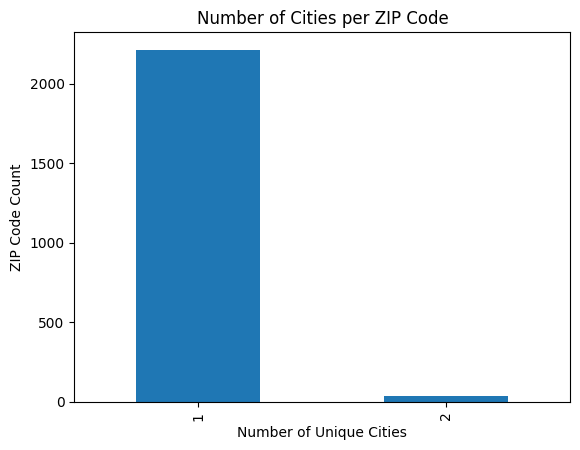

In [270]:
# ZIP 코드별로 연결된 고유 도시 수 확인
zip_city_check = sellers.groupby('seller_zip_code_prefix')['seller_city'].nunique()

zip_city_check.value_counts().sort_index().plot(kind='bar')
plt.title("Number of Cities per ZIP Code")
plt.xlabel("Number of Unique Cities")
plt.ylabel("ZIP Code Count")
plt.show()


In [271]:
# ZIP에 연결된 고유 도시 수 세기
zip_city_check = sellers.groupby('seller_zip_code_prefix')['seller_city'].nunique()

# 2개 이상 도시가 연결된 ZIP 코드만 필터링
multi_city_zips = zip_city_check[zip_city_check > 1].index.tolist()

# 해당 ZIP 코드에 연결된 도시 목록 추출
zip_city_pairs = sellers[sellers['seller_zip_code_prefix'].isin(multi_city_zips)] \
                    .groupby(['seller_zip_code_prefix', 'seller_city']) \
                    .size().reset_index(name='count')

# 정렬해서 보기 좋게 출력
zip_city_pairs = zip_city_pairs.sort_values(by='seller_zip_code_prefix')

# ZIP에 연결된 고유 도시 수 세기
zip_city_check = sellers.groupby('seller_zip_code_prefix')['seller_city'].nunique()

# 2개 이상 도시가 연결된 ZIP 코드만 필터링
multi_city_zips = zip_city_check[zip_city_check > 1].index.tolist()

In [272]:
# zip 확인
zip_city_pairs.head(20)

,seller_zip_code_prefix,seller_city,count
0,01207,sao paulo,1
1,01207,sao paulo sp,1
2,05141,pirituba,1
3,05141,sp,1
4,07077,garulhos,1
5,07077,guarulhos,1
6,08710,mogi das cruses,1
7,08710,mogi das cruzes,4
8,09190,sando andre,1
9,09190,santo andre,2


동일 우편번호에서 여러 셀러시티가 존재함    
각 셀러들이 도시명을 입력시 하위 지역명 또는 도시명 또는 포르투칼어나 영어로 기재한것으로 확인    
해당 데이터는 정제과정이 오래걸릴것으로 생각되며 state(주) 칼럼을 사용하기로 결정함.

## Orders 전처리

In [273]:
# Orders 데이터 확인하기
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


| 컬럼명                              | 설명                                                     |
| -------------------------------- | ------------------------------------------------------ |
| **orders데이터 설명:**           | Olist 데이터셋에서 주문(transaction) 정보를 담고 있는 핵심 테이블로 각 컬럼은 주문의 상태나 시간의 정보 등을 자세히 기록하고 있습니다. |
| order\_id                        | 주문의 고유 ID. `order_items`, `order_reviews` 등과 연결될 때 사용됨 |
| customer\_id                     | 주문한 고객의 ID. `customers` 테이블과 연결 가능                     |
| order\_status                    | 주문 상태. 예: `delivered`, `shipped`, `canceled` 등         |
| order\_purchase\_timestamp       | 고객이 주문을 완료한 시간 (구매 시점)                                 |
| order\_approved\_at              | 결제가 승인된 시간                                             |
| order\_delivered\_carrier\_date  | 물류업체가 제품을 수령한 날짜 (배송 시작 시점)                            |
| order\_delivered\_customer\_date | 고객이 실제로 제품을 받은 날짜                                      |
| order\_estimated\_delivery\_date | 시스템이 예측한 예상 배송일 (약속된 날짜)                               |


In [274]:
# orders 결측치 확인하기
orders.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


고유 값 order_id , customer_id 두 컬럼은 제외하고 이상치 및 결측치를 확인해보겠습니다.

In [275]:
# order_status 칼럼값 갯수 확인하기.
orders['order_status'].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


canceled, unavailable 건은 거래가 확실하게 이루어지지 않은것으로 판단하고 삭제처리하겠습니다.

In [276]:
# canceled, unavailable 거래건 삭제하기
orders = orders[~orders['order_status'].isin(['canceled', 'unavailable'])].copy()

In [277]:
# 삭제된 데이터 확인
orders['order_status'].value_counts()

,count
order_status,
delivered,96478
shipped,1107
invoiced,314
processing,301
created,5
approved,2


In [278]:
# order_purchase_timestamp - 결측치 있었지만 order_status == 'canceled' 가 삭제되며 삭제됨.
orders[orders['order_purchase_timestamp'].isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [279]:
# order_approved_at - 결제 승인이 누락됐지만 배송완료 처리됨. 승인만 문제 이므로 행 유지.
orders['order_approved_at']
orders[orders['order_approved_at'].isna()] #

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaN,NaN,NaN,2018-01-11 00:00:00
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaN,NaN,NaN,2018-03-07 00:00:00
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaN,NaN,NaN,2017-12-12 00:00:00
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00


In [280]:
# order_delivered_carrier_date
# 배송 준비중이거나 판매자의 누락에 의한 부분이지만 우리 분석에서는 큰 영향이 없어서 삭제하지 않고 유지.
orders[orders['order_delivered_carrier_date'].isna()]

orders[(orders['order_delivered_carrier_date'].isna()) &
    (orders['order_status'] != 'delivered')]

statuses = ['delivered', 'shipped', 'canceled', 'invoiced', 'processing', 'unavailable', 'approved']

for status in statuses:
    count = len(orders[(orders['order_delivered_carrier_date'].isna()) & (orders['order_status'] == status)])
    print(f"{status} : {count}")

delivered : 2
shipped : 0
canceled : 0
invoiced : 314
processing : 301
unavailable : 0
approved : 2


In [281]:
# order_delivered_customer_date

orders[orders['order_delivered_customer_date'].isna()]

# 고객에게 실제 배송된 날짜 및 시간
# 도착 안한 물품들도 많고, order_status가 이미 delivered지만 기입 안된 것도 존재.
# 데이터셋 기준에서 주문이 발생한 것들은 구매 완료로 생각할 것이므로 해당 데이터들 유지.
# 배송 시간을 측정할 것이 아니기 때문에 분석에는 필요없음.

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00
...,...,...,...,...,...,...,...,...
99066,46bdec7cc92d926500bee756ee1df6dc,0cfcefc0ed0af6a2e601540feeac24e7,invoiced,2018-07-16 13:20:06,2018-07-16 13:30:35,NaN,NaN,2018-08-06 00:00:00
99113,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaN,2018-07-24 00:00:00
99140,aea0db338150b526dde24f6fd953a5ed,379a02efdc6a56bd27f99b95fc2f6c06,processing,2017-12-26 21:56:13,2017-12-26 22:05:26,NaN,NaN,2018-01-26 00:00:00
99181,636cdd02667dc8d76d9296bf20a6890a,c162256b133c76f79181ce61d66545db,shipped,2018-02-17 14:31:22,2018-02-20 07:11:31,2018-02-20 19:18:58,NaN,2018-03-14 00:00:00


## order_item 전처리

In [282]:
# 데이터 확인하기
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


| 컬럼명                   | 설명                                          |
| --------------------- | ------------------------------------------- |
| **order_items 테이블설명 :** | 각 주문에 포함된 상품 하나하나의 상세정보를 담고있습니다. orders는 주문단위이고 order_itme은 주문속 개별 상품 단위로 더 세부적인 정보를 담고있다. |
| order\_id             | 주문 ID (`orders.order_id`와 연결됨)              |
| order\_item\_id       | 주문 내에서의 상품 순번 (1번, 2번 … 같은 식으로 번호 매김)       |
| product\_id           | 제품 ID (`products.product_id`와 연결됨)          |
| seller\_id            | 해당 상품을 판매한 셀러 ID (`sellers.seller_id`와 연결됨) |
| shipping\_limit\_date | 셀러가 물건을 발송해야 하는 마감 기한                       |
| price                 | 해당 상품의 판매 가격 (수량 1개 기준)                     |
| freight\_value        | 배송비 (freight = 운임)                          |


In [283]:
# order_items 테이블 구조 확인
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [284]:
# 컬럼별 결측치 개수 확인
order_items.isnull().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0


In [285]:
# price가 0인 행만 필터링
price_zero_items = order_items[order_items['price'] == 0]

# 상위 5개 행 확인
price_zero_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


모든 items의 가격은 결측치도없고, 0인경우도 없는것으로 확인됩니다.

order_item_id가 0 이하인 경우는 정상적이지 않은 값일 확률이 있으므로 0값이 존재하는지 확인해보겠습니다.

In [286]:
# order_item_id가 0 이하인 행 추출
invalid_item_ids = order_items[order_items['order_item_id'] <= 0]

# 결과 확인
invalid_item_ids

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


order_item_id도 0이하인 경우는 없는것으로 확인되며 전처리를 추가적으로 할건 없는것으로 확인됩니다.

## Products 전처리

In [287]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


| 컬럼명                          | 설명                                       |
| ---------------------------- | ---------------------------------------- |
| product\_id                  | 상품의 고유 ID. `order_items.product_id`와 연결됨 |
| product\_category\_name      | 상품의 카테고리 (product\_category\_name은 포루투칼어 이기 때문에 \_product_category_name_translation 테이블과 연결하면 영어로 볼 수 있다. )|
| product\_name\_lenght        | 상품 이름의 길이 (문자 수)                         |
| product\_description\_lenght | 상품 설명의 길이 (문자 수)                         |
| product\_photos\_qty         | 등록된 상품 이미지 수                             |
| product\_weight\_g           | 상품의 무게 (그램 단위)                           |
| product\_length\_cm          | 상품 길이 (cm)                               |
| product\_height\_cm          | 상품 높이 (cm)                               |
| product\_width\_cm           | 상품 너비 (cm)                               |



In [288]:
# products 테이블 구조 및 결측치 확인
products.info()
products.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


제일먼저 product_category_name의 경우 포르투칼어로 되어있기 때문에 category_translation 테이블과 병합하여 product_category를 영어로 치환해보겠습니다.

`on='product_category_name'`: 포르투갈어 카테고리명을 기준으로 병합    
`how='left'`: products 테이블에 있는 모든 행을 유지 (카테고리명이 없는 경우 영어는 NaN으로 남음)    
`product_category_name_english`: 영어 번역 컬럼으로 새로 생성

In [289]:
# category_translation 테이블과 병합하여 영어 카테고리명을 추가
products = pd.merge(products, category_translation, on='product_category_name', how='left')

# 병합 결과 확인 (포르투갈어/영어 카테고리 함께 출력)
products[['product_id', 'product_category_name', 'product_category_name_english']].head()

,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


추가된 컬럼과 함께 전체 결측치 재확인하기

In [290]:
# 결측치 갯수 확인하기
products.isnull().sum()

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2
product_category_name_english,623


영어 카데고리명이 매핑이 안된 카테고리가 있다는것을 확인했습니다. 영어 이름이 없는 카테고리를 확인해보겠습니다.

In [291]:
# 영어 이름이 없는 카테고리 확인
missing_categories = products[products['product_category_name_english'].isnull()]['product_category_name'].unique()
missing_categories

array([nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'],
      dtype=object)

In [292]:
# 전체 카테고리 수 중 누락된 카테고리 수
total_categories = products['product_category_name'].nunique()
missing_count = len(missing_categories)
print(f"전체 카테고리 수: {total_categories}, 누락된 카테고리 수: {missing_count} ({(missing_count/total_categories)*100:.2f}%)")


전체 카테고리 수: 73, 누락된 카테고리 수: 3 (4.11%)


In [293]:
# 결측치 수동 매핑용 딕셔너리 정의
manual_translation = {
    'pc_gamer': 'Gaming PC',
    'portateis_cozinha_e_preparadores_de_alimentos': 'Portable Kitchen Appliances'
}

# 결측치인 행만 수동으로 영어 이름 채우기
products['product_category_name_english'] = products.apply(
    lambda row: manual_translation[row['product_category_name']]
    if pd.isnull(row['product_category_name_english']) and row['product_category_name'] in manual_translation
    else row['product_category_name_english'],
    axis=1
)

In [294]:
# 매핑 후 결측치 갯수 확인하기
print(products.isnull().sum())
print('-'*20)
print(products['product_category_name'].nunique())

product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    610
dtype: int64
--------------------
73


카테고리가 없는 컬럼의 경우 사용할 수 없을거라고 판단하여 NULL값을 삭제해주겠습니다.

In [295]:
# product_category_name 컬럼에서 NaN 값 제거
products = products[products['product_category_name'].notnull()]

# 결과 확인
print("결측치 제거 후 products shape:", products.shape)
print("남아 있는 product_category_name 종류 수:", products['product_category_name'].nunique())


결측치 제거 후 products shape: (32341, 10)
남아 있는 product_category_name 종류 수: 73


In [296]:
# 'product_category_name' 결측치 삭제 후 결측치 갯수 확인하기
products.isnull().sum()

,0
product_id,0
product_category_name,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,1
product_length_cm,1
product_height_cm,1
product_width_cm,1
product_category_name_english,0


우리는 카테고리의 값만 사용할 예정으로 무게와 길이정보가 없더라도 해당 결측치는 삭제하지않고 가져가도록 하겠습니다.    
추가적으로 product_category_name의 경우 포르투칼어를 사용하지 않을 예정으로 해당 칼럼은 삭제하도록 하겠습니다.

In [297]:
# 포르투갈어 카테고리명 삭제
products.drop(columns=['product_category_name'], inplace=True)

# 삭제 결과 확인
print("컬럼 삭제 후 컬럼 목록:")
print(products.columns)

컬럼 삭제 후 컬럼 목록:
Index(['product_id', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')


<ipython-input-297-658fab264bba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  products.drop(columns=['product_category_name'], inplace=True)


## Payment 전처리

In [298]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


| 컬럼명                   | 설명                                      |
| --------------------- | --------------------------------------- |
| **order\_payments 설명 :**| 주문별 결제 정보를 담고 이쏙 특히 결제수단, 할부 개수, 결제 금액 등 결제 방식에 대한 테이블 `payment\_value` 테이블을 중점적으로 사용할 예정 |
| order\_id             | 주문 ID (`orders.order_id`와 연결됨)          |
| payment\_sequential   | 결제 순서 (하나의 주문이 여러 번에 걸쳐 결제된 경우 순번)      |
| payment\_type         | 결제 방식 (credit\_card, boleto, voucher 등) |
| payment\_installments | 할부 개수 (installments 수)                  |
| payment\_value        | 해당 결제의 금액 (총액이 아님. 분할 결제 시 나뉘어 있을 수 있음) |


In [299]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [300]:
# 결측치 확인하기
order_payments.isnull().sum()

,0
order_id,0
payment_sequential,0
payment_type,0
payment_installments,0
payment_value,0


각 컬럼의 결측치 확인 - 모두 정상    
각 컬럼별 표준통계를 통한 이상치 확인    
| 컬럼명 | 설명 | 주의할 점 |
| --- | --- | --- |
| `payment_sequential` | 같은 주문에서 여러 결제 수단이 쓰인 경우 순서를 나타냄 | 대부분 1, 최대 29로 보아 **중복 결제** 또는 **부분 결제** 가능성? —> 여러번의 결제의 원인인 Voucher사용으로 보여짐 |
| `payment_installments` | 할부 횟수 | **0인 경우 존재함 → 이상치 또는 에러? —> 할부 횟수가 0인 경우는 바우처를 사용했을 경우, 확인되지 않는 경우에 한함 —> 이상치 보다는 현실에서 충분히 발생가능성이 있어 자료를 그대로 둠** |
| `payment_value` | 결제 금액 | **0원인 경우 존재함** → 무료 주문인지, 에러인지 판단 필요  |

In [301]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


## geolocation 전처리

In [302]:
# geolocation 데이터 확인하기 ( 지리적 위치정보를 담고있는 테이블 )
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


| 컬럼명                           | 설명                                          |
| ----------------------------- | ------------------------------------------- |
| **geolocation데이터설명** :  |이 테이블은 브라질 전체의 지리 정보를 담고있는 정보로 customers나 sellers 테이블의 우편번호 prefix를 기준으로 위치 좌표를 추정할 수 있다. |
| geolocation_zip_code_prefix | 우편번호 앞 5자리 (prefix). 고객이나 seller의 지역 식별에 사용 |
| geolocation_lat             | 위도 (latitude)                               |
| geolocation_lng             | 경도 (longitude)                              |
| geolocation_city            | 도시 이름                                       |
| geolocation_state           | 주(State) 이름 (예: SP, RJ 등)                   |


우선 브라질 지도위에 모든 값을 산점도에 찍어보도록 하겠습니다.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

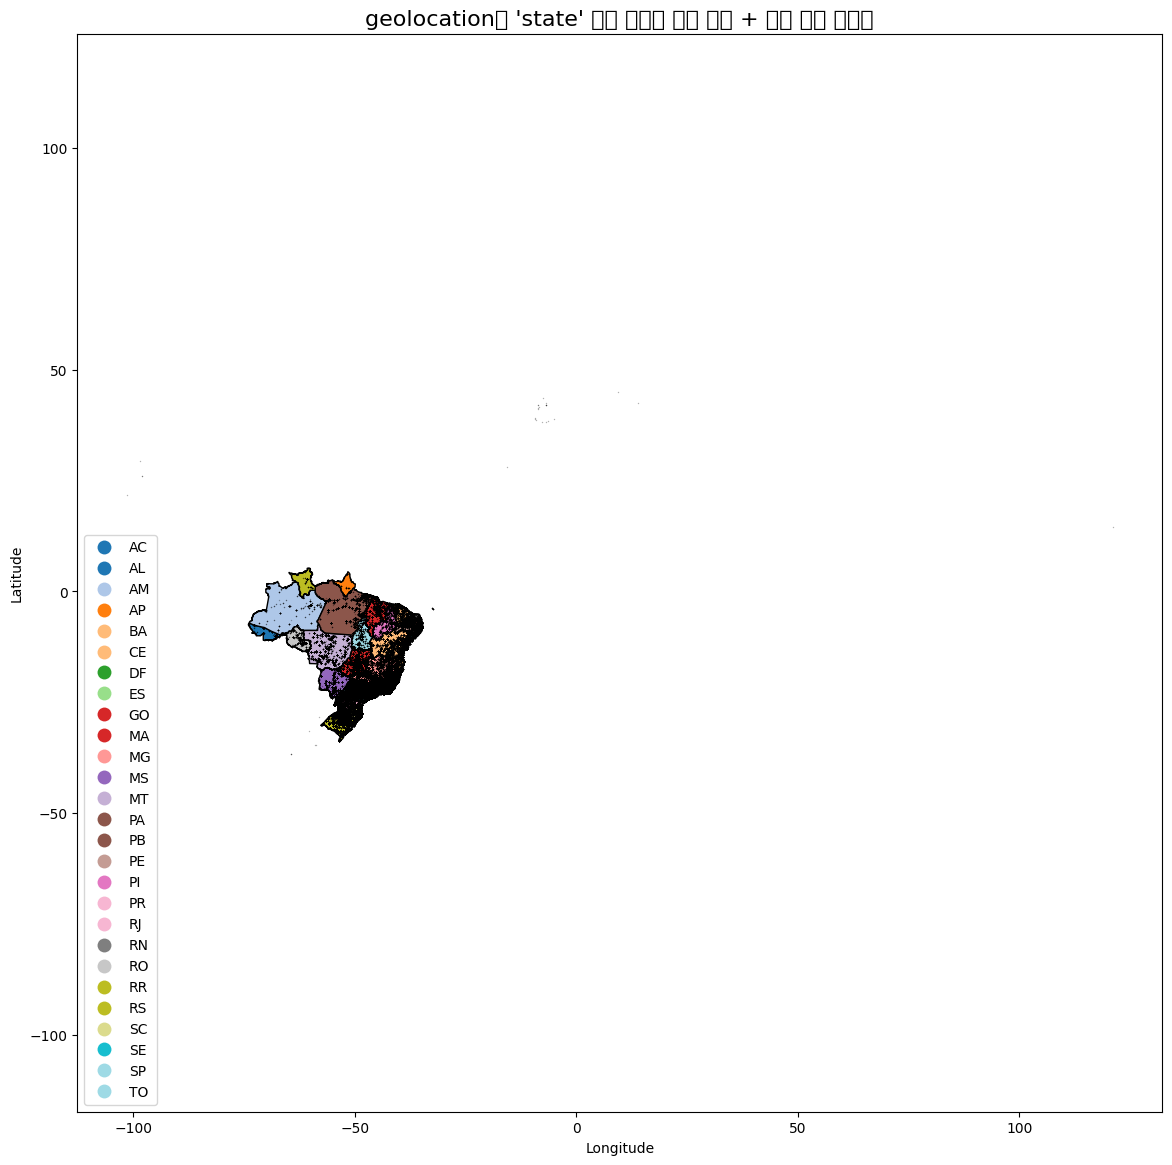

In [303]:
# 0. 브라질 주 경계 GeoJSON 불러오기
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brazil_states = gpd.read_file(url)

# 2. geolocation 위도/경도 → GeoDataFrame 변환
gdf_geo = gpd.GeoDataFrame(
    geolocation,
    geometry=gpd.points_from_xy(geolocation['geolocation_lng'], geolocation['geolocation_lat']),
    crs="EPSG:4326"
)

# 3. 'state' 기준으로 색상 입히기 위해, GeoJSON의 'sigla' 컬럼명을 확인
# 일반적으로 'sigla'는 두 글자 주 약어 (예: SP, RJ, AM)
# geolocation['state']와 동일한 포맷인지 확인 필요

# 4. 시각화 시작
fig, ax = plt.subplots(figsize=(14, 14))

# GeoJSON의 'sigla' 기준으로 색상 구분 (geolocation 기준과 일치)
brazil_states.plot(column='sigla', cmap='tab20', legend=True, ax=ax, edgecolor='black')

# 산점도 추가 (geolocation의 모든 점)
sns.scatterplot(
    x=gdf_geo.geometry.x,
    y=gdf_geo.geometry.y,
    color='black',
    s=1,
    alpha=0.3,
    ax=ax,
    linewidth=0
)

# 제목 및 축 설정
plt.title("geolocation의 'state' 기준 브라질 주별 색상 + 전체 좌표 산점도", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()

위 값을 확인결과 지도 주변의 다른 국가에서도 주문한것을 확인할 수 있습니다.    
브라질 외각에서 주문한 데이터에 대해서는 삭제처리를 하도록 하겠습니다.    

In [304]:
# 1. 좌표를 Point로 변환
gdf_geo = gpd.GeoDataFrame(
    geolocation,
    geometry=gpd.points_from_xy(geolocation['geolocation_lng'], geolocation['geolocation_lat']),
    crs="EPSG:4326"
)

# 2. 브라질 경계로 공간 조인 수행 (포함 여부 판단)
gdf_joined = gpd.sjoin(gdf_geo, brazil_states[['sigla', 'geometry']], how='left', predicate='within')

# 3. 브라질 내에 포함되지 않은 (NaN) 좌표 필터링
gdf_outliers = gdf_joined[gdf_joined['sigla'].isna()]

# 4. 브라질 외 좌표 제거
gdf_brazil = gdf_joined[~gdf_joined['sigla'].isna()].copy()

# 5. 필요한 컬럼만 정리 (원래 geolocation 형태로)
gdf_brazil.drop(columns=['index_right'], inplace=True)

# 6. 결과 확인
print(f"총 원본 geolocation 개수: {len(gdf_geo)}")
print(f"브라질 외 지역 좌표 개수: {len(gdf_outliers)}")
print(f"브라질 내 좌표 개수: {len(gdf_brazil)}")

총 원본 geolocation 개수: 1000163
브라질 외 지역 좌표 개수: 1460
브라질 내 좌표 개수: 998703


In [305]:
gdf_brazil.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geometry,sigla
0,1037,-23.545621,-46.639292,sao paulo,SP,POINT (-46.63929 -23.54562),SP
1,1046,-23.546081,-46.644820,sao paulo,SP,POINT (-46.64482 -23.54608),SP
2,1046,-23.546129,-46.642951,sao paulo,SP,POINT (-46.64295 -23.54613),SP
3,1041,-23.544392,-46.639499,sao paulo,SP,POINT (-46.6395 -23.54439),SP
4,1035,-23.541578,-46.641607,sao paulo,SP,POINT (-46.64161 -23.54158),SP


위 불필요한 컬럼들을 삭제하면서 `sigla` 에 경도와 위도를 기준으로 실제 주(state)의 값이 생성된것을 확인했습니다.    
하단에서 주(state)정보를 확인하면서 전처리 할 때 사용하도록 하겠습니다.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

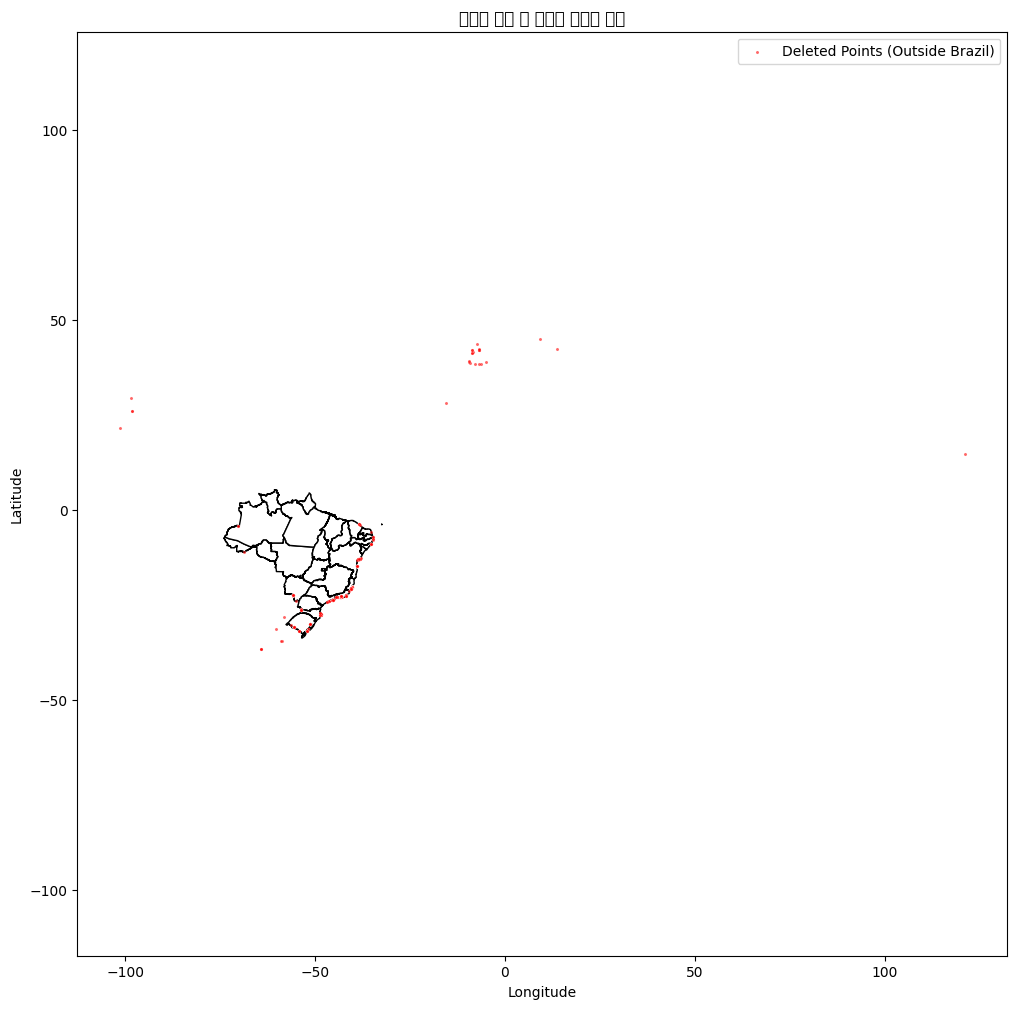

In [306]:
# 브라질 범위 밖 세저된 이상치 좌표 시각화
plt.figure(figsize=(12, 12))
brazil_states.plot(ax=plt.gca(), color='white', edgecolor='black')

# 브라질 외 지역 점 (삭제 대상)
sns.scatterplot(
    x=gdf_outliers.geometry.x,
    y=gdf_outliers.geometry.y,
    color='red',
    s=5,
    alpha=0.6,
    label='Deleted Points (Outside Brazil)'
)

plt.title("브라질 범위 밖 삭제된 이상치 좌표")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.axis('equal')
plt.show()


이제 외각지역 데이터는 삭제하고 남은 데이터로 시각화하여 확인해보겠습니다.

<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-307-f820a5ea6736>:31: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ip

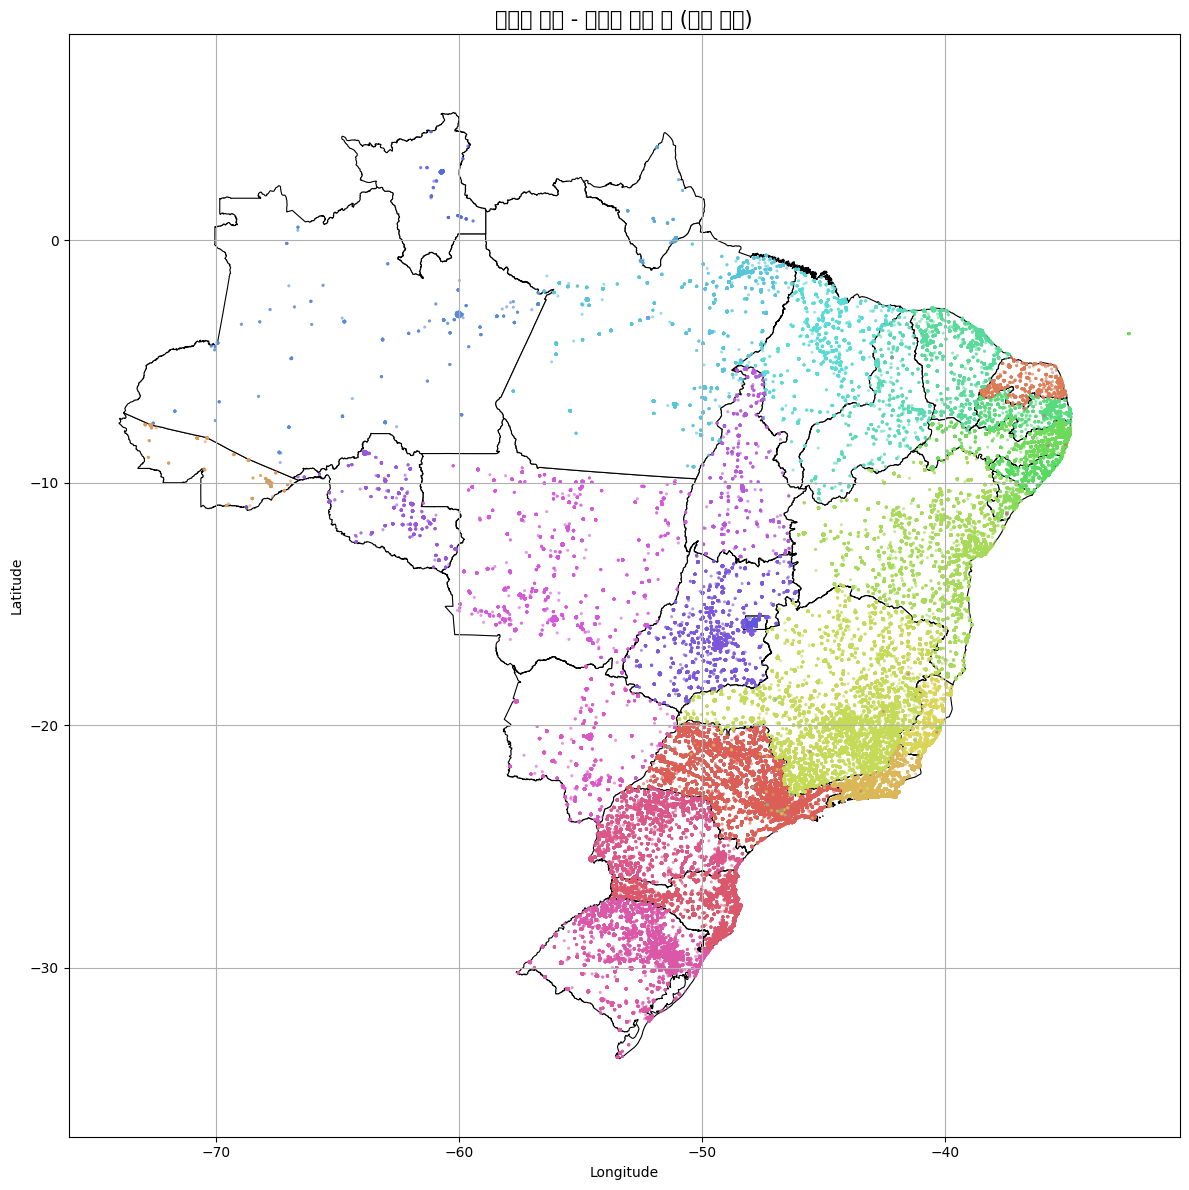

In [307]:
# 1. longitude, latitude 컬럼 생성
gdf_brazil['longitude'] = gdf_brazil.geometry.x
gdf_brazil['latitude'] = gdf_brazil.geometry.y

# 2. 시각화
plt.figure(figsize=(12, 12))
brazil_states.plot(
    ax=plt.gca(),
    color='white',
    edgecolor='black',
    linewidth=0.8
)

sns.scatterplot(
    data=gdf_brazil,
    x='longitude',
    y='latitude',
    hue='geolocation_state',
    palette='hls',
    s=5,
    alpha=0.6,
    linewidth=0
)

plt.title("브라질 지도 - 이상치 제거 후 (주별 색상)", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.axis('equal')
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()


위 시각한 데이터를 확인결과 각주에 찍혀있어야하는 state의 색상이 조금씩 다른것으로 보이며 정확한 state값이 아닌것으로 확인됩니다.         
위에 언급했던 SP 칼럼을 사용하여 다시 시각화를 해보고 정확한 데이터라고 판단되면 sp칼럼을 state칼럼으로 교체하겠습니다.

<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-308-5ed598bd2ad8>:35: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ip

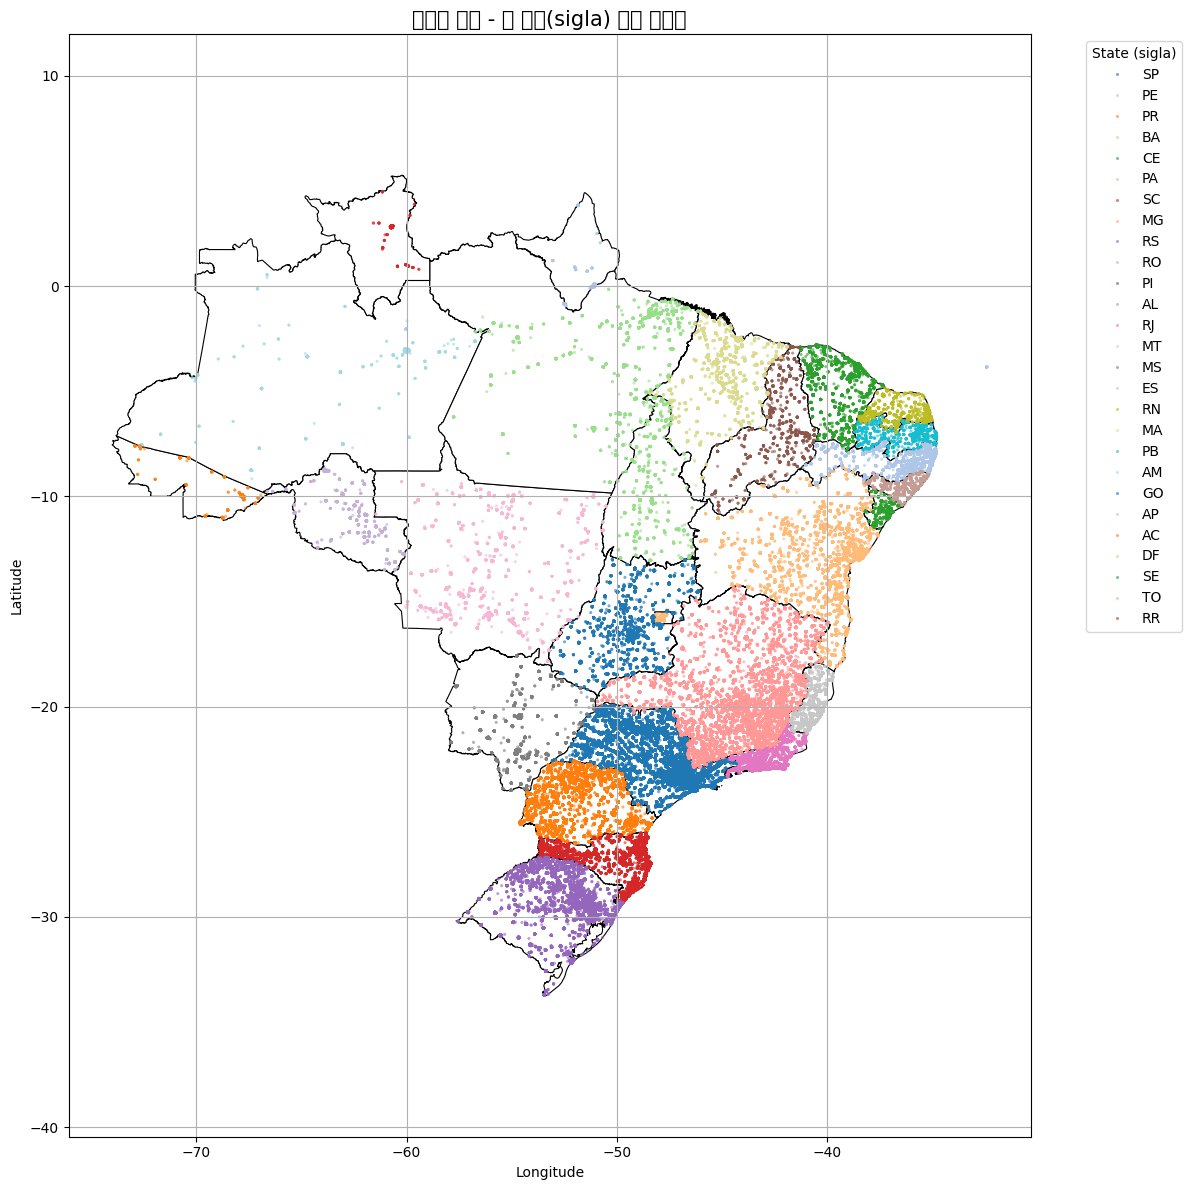

In [308]:
# 1. 좌표 컬럼 생성
gdf_brazil['longitude'] = gdf_brazil.geometry.x
gdf_brazil['latitude'] = gdf_brazil.geometry.y

# 2. 시각화
plt.figure(figsize=(12, 12))

# 브라질 주 경계선 그리기
brazil_states.plot(
    ax=plt.gca(),
    color='white',
    edgecolor='black',
    linewidth=0.8
)

# sigla 기준 색상 산점도
sns.scatterplot(
    data=gdf_brazil,
    x='longitude',
    y='latitude',
    hue='sigla',          # 주 약어 기준으로 색상
    palette='tab20',      # 최대 20개의 구분 색상
    s=5,
    alpha=0.6,
    linewidth=0
)

# 그래프 꾸미기
plt.title("브라질 지도 - 주 약어(sigla) 기준 산점도", fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.grid(True)
plt.legend(title='State (sigla)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [309]:
# geolocation_state와 spatial join 결과(state_code)가 다른 행만 필터링
mismatches = gdf_brazil[
    gdf_brazil['geolocation_state'] != gdf_brazil['sigla']
]

# 불일치 갯수 확인
print(f"총 불일치 개수: {len(mismatches)}")

총 불일치 개수: 380


In [310]:
# 3. 확인용으로 서로 일치하지 않는 값들의 핵심 컬럼만 추출하여 일부 출력
mismatches

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,geometry,sigla,longitude,latitude
22261,2116,-23.515978,-46.582170,são paulo,RN,POINT (-46.58217 -23.51598),SP,-46.582170,-23.515978
72852,4011,-23.578707,-46.645779,sao paulo,AC,POINT (-46.64578 -23.57871),SP,-46.645779,-23.578707
250816,11200,-8.275689,-35.965615,caruara,SP,POINT (-35.96562 -8.27569),PE,-35.965615,-8.275689
266081,11955,-24.758294,-48.507566,barra do turvo,SP,POINT (-48.50757 -24.75829),PR,-48.507566,-24.758294
266175,11955,-24.758294,-48.507566,barra do turvo,SP,POINT (-48.50757 -24.75829),PR,-48.507566,-24.758294
...,...,...,...,...,...,...,...,...,...
958168,93609,-26.917427,-49.083663,estância velha,RS,POINT (-49.08366 -26.91743),SC,-49.083663,-26.917427
958328,93608,-11.275710,-37.447485,estancia velha,RS,POINT (-37.44749 -11.27571),SE,-37.447485,-11.275710
961598,94760,-19.435588,-42.520206,aguas claras,RS,POINT (-42.52021 -19.43559),MG,-42.520206,-19.435588
962368,94931,-23.464081,-46.664721,cachoeirinha,RS,POINT (-46.66472 -23.46408),SP,-46.664721,-23.464081


**최종적으로 sigla의 컬럼은 위도 경도를 기반으로 한 state값이 들어간것을 확인했습니다.**

이제 불필요한 컬럼을 제거하고 이름을 변경하여 geolocation에 저장해보겠습니다.     
`geolocation_zip_code_prefix` 코드의경우 선행된 0 이 다시 돌아올 수 있도록 문자열로 변환하고 5자리의 zip 코드로 변환시켜주겠습니다.

In [311]:
# 1. 불필요한 컬럼 제거 및 이름 변경을 위한 작업

# 1-1. ‘geolocation_state’ (원본) 컬럼 제거
#    - 원본 데이터셋에 있던 주 정보이며, 공간 조인 결과(sigla)와 혼동되지 않도록 삭제합니다.
gdf_brazil.drop(columns=['geolocation_state'], inplace=True)

# 1-2. ‘geometry’ 컬럼 제거
#    - 위도·경도 정보는 이미 longitude, latitude 컬럼으로 추출했으므로,
#      공간(Geo) 정보가 담긴 geometry 컬럼은 더 이상 필요하지 않습니다.
gdf_brazil.drop(columns=['geometry'], inplace=True)

# 1-3. ‘sigla’ 컬럼을 ‘geolocation_state’로 이름 변경
#    - 공간 조인(sjoin) 결과로 생성된 sigla 컬럼은
#      실제 위도·경도 기준으로 판별된 주 약어이므로,
#      최종 데이터에서는 이 값을 ‘geolocation_state’로 사용합니다.
gdf_brazil.rename(columns={'sigla': 'geolocation_state'}, inplace=True)

# 1-4. ‘longitude’, ‘latitude’ 컬럼 제거
#    - 시각화를 위해 잠시 사용했던 위도·경도 컬럼이며,
#      최종적으로는 좌표가 아닌 주 코드와 우편번호만 남기고자 합니다.
gdf_brazil.drop(columns=['longitude', 'latitude'], inplace=True)

# 2. ‘geolocation_zip_code_prefix’에 선행 0(zfill) 추가
#    - 우편번호 앞에 0이 빠진 경우가 있어 5자리로 통일합니다.
#    - 예: 123 → "00123"
gdf_brazil['geolocation_zip_code_prefix'] = (
    gdf_brazil['geolocation_zip_code_prefix']
    .astype(str)   # 문자열로 변환한 뒤
    .str.zfill(5)  # 5자리 맞추기
)

# 3. 최종 컬럼 구조 확인
print("최종 컬럼 목록:", list(gdf_brazil.columns))
print("\n샘플 데이터 (상위 5행):")
display(gdf_brazil.head())

최종 컬럼 목록: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

샘플 데이터 (상위 5행):


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


In [312]:
gdf_brazil

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [313]:
# 최종 정제된 데이터를 geolocation 변수에 저장
geolocation = gdf_brazil.copy()

### **최종적으로 모든 전처리가 완료되었으므로 merge를 통해 모든 데이터를 통합하겠습니다.**

# 데이터 통합하기

In [314]:
# 1. orders + order_items
merge_df = pd.merge(orders, order_items, on='order_id', how='left')

# 2. + sellers
merge_df = pd.merge(merge_df, sellers, on='seller_id', how='left')

# 3. + products
merge_df = pd.merge(merge_df, products, on='product_id', how='left')

# 4. + customers
merge_df = pd.merge(merge_df, customers, on='customer_id', how='left')

# 5. + order_payments
merge_df = pd.merge(merge_df, order_payments, on='order_id', how='left')

# 6. + order_reviews
merge_df = pd.merge(merge_df, order_reviews, on='order_id', how='left')

# 결과 확인
print("병합 완료된 mergedf shape:", merge_df.shape)

병합 완료된 mergedf shape: (117741, 39)


In [315]:
# 1. geolocation에서 중복 제거 후 필요한 컬럼만 추출
geo_unique = geolocation.drop_duplicates(subset='geolocation_zip_code_prefix')[
    ['geolocation_zip_code_prefix', 'geolocation_state']
]

# 2. 고객용 지오로케이션 준비 (컬럼 이름 변경)
geo_customer = geo_unique.rename(
    columns={
        'geolocation_zip_code_prefix': 'customer_zip_code_prefix',
        'geolocation_state': 'geolocation_state_customer'
    }
)

# 3. 판매자용 지오로케이션 준비 (컬럼 이름 변경)
geo_seller = geo_unique.rename(
    columns={
        'geolocation_zip_code_prefix': 'seller_zip_code_prefix',
        'geolocation_state': 'geolocation_state_seller'
    }
)

# 4. 고객 기준 병합
merge_df = pd.merge(
    merge_df,
    geo_customer,
    on='customer_zip_code_prefix',
    how='left'
)

# 5. 판매자 기준 병합
merge_df = pd.merge(
    merge_df,
    geo_seller,
    on='seller_zip_code_prefix',
    how='left'
)

In [316]:
merge_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_state_customer,geolocation_state_seller
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,09350,maua,SP,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,03149,sao paulo,SP,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,SP,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,09350,maua,SP,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,03149,sao paulo,SP,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,SP,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,09350,maua,SP,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,7c396fd4830fd04220f754e42b4e5bff,03149,sao paulo,SP,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,SP,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,31570,belo horizonte,SP,29.0,178.0,1.0,400.0,19.0,13.0,19.0,perfumery,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,BA,MG
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,14840,guariba,SP,46.0,232.0,1.0,420.0,24.0,19.0,21.0,auto,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,GO,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117736,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,17602,tupa,SP,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,baby,da62f9e57a76d97

In [317]:
# product_category_name_english 누락으로 인한 행 제거
merge_df = merge_df.dropna(subset=['product_category_name_english'])

In [318]:
# customer_zip_code_prefix, seller_zip_code_prefix 컬럼이
# geolocation의 geolocation_zip_code_prefix과 일치하는 부분이 없어서
# 누락된 부분이 존재함.
# 최대한 데이터를 살리고자 Nan 값에 한해서 기존 state를 불러온다.
merge_df['geolocation_state_customer'] = merge_df['geolocation_state_customer'].fillna(merge_df['customer_state'])
merge_df['geolocation_state_seller'] = merge_df['geolocation_state_seller'].fillna(merge_df['seller_state'])

<ipython-input-318-6dcbe3b614ac>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['geolocation_state_customer'] = merge_df['geolocation_state_customer'].fillna(merge_df['customer_state'])
<ipython-input-318-6dcbe3b614ac>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['geolocation_state_seller'] = merge_df['geolocation_state_seller'].fillna(merge_df['seller_state'])


In [319]:
# 결제 금액 누락으로 인한 행 제거
merge_df = merge_df.dropna(subset=['payment_value'])

In [320]:
# 나머지 부분의 Null은 우리 분석에는 큰 지장이 없는 부분이다.
# 일단 전체 데이터셋의 통합을 만들기 위한 과정으로 이 Null들은 삭제하지 않는다.

null_counts = merge_df.isnull().sum()
print(null_counts[null_counts > 0].sort_values(ascending=False))

review_comment_title             102312
review_comment_message            67486
order_delivered_customer_date      1962
review_id                           947
review_score                        947
review_creation_date                947
review_answer_timestamp             947
order_delivered_carrier_date        731
order_approved_at                    14
product_length_cm                     1
product_weight_g                      1
product_height_cm                     1
product_width_cm                      1
dtype: int64


In [321]:
# 병합된 mergedf를 CSV 파일로 저장
merge_df.to_csv("merge_df.csv", index=False)